In [1]:
%load_ext autoreload
# change import path 
import sys
sys.path.append('../../src')
# auto reload module


In [2]:
from preprocessing.pre_processor import PreProcessor

In [3]:
# import roberta tokeizer fast
from transformers import RobertaTokenizerFast

# import torch
import torch

# import torch dataset

In [28]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

batch_size = 2
num_sentences = 24
max_sentence_length = 64
max_args_per_sentence = 10
max_arg_length = 16 
test_size = 0.1
frameaxis_dim = 10
name_tokenizer = 'roberta-base'
path_name_bert_model = 'roberta-base'
path_antonym_pairs = '../../data/axis/mft.json'
dim_names = ["virtue","vice"]
class_column_names = "Capacity and Resources;Crime and Punishment;Cultural Identity;Economic;External Regulation and Reputation;Fairness and Equality;Health and Safety;Legality, Constitutionality, Jurisdiction;Morality;Other;Policy Prescription and Evaluation;Political;Public Sentiment;Quality of Life;Security and Defense".split(";")

In [5]:
# Preprocess the input
preprocessor = PreProcessor(
    tokenizer,
    batch_size=batch_size,
    max_sentences_per_article=num_sentences,
    max_sentence_length=max_sentence_length,
    max_args_per_sentence=max_args_per_sentence,
    max_arg_length=max_arg_length,
    test_size=test_size,
    frameaxis_dim=frameaxis_dim,
    bert_model_name=name_tokenizer,
    name_tokenizer=name_tokenizer,
    path_name_bert_model=path_name_bert_model,
    path_antonym_pairs=path_antonym_pairs,
    dim_names=dim_names,
    class_column_names=class_column_names,
)

In [30]:
random_state = 42

In [31]:
train_df, test_df = preprocessor.get_dataframe(
    "../../data/mfc/immigration_labeled_preprocessed.json",
    "json",
    dataframe_path={
        "srl": "../../data/srls/mfc/mfc_labeled.pkl",
        "frameaxis": "../../data/frameaxis/mfc/frameaxis_mft.pkl",
    },
    force_recalculate={
        "srl": False,
        "frameaxis": False,
    },
    random_state=random_state,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


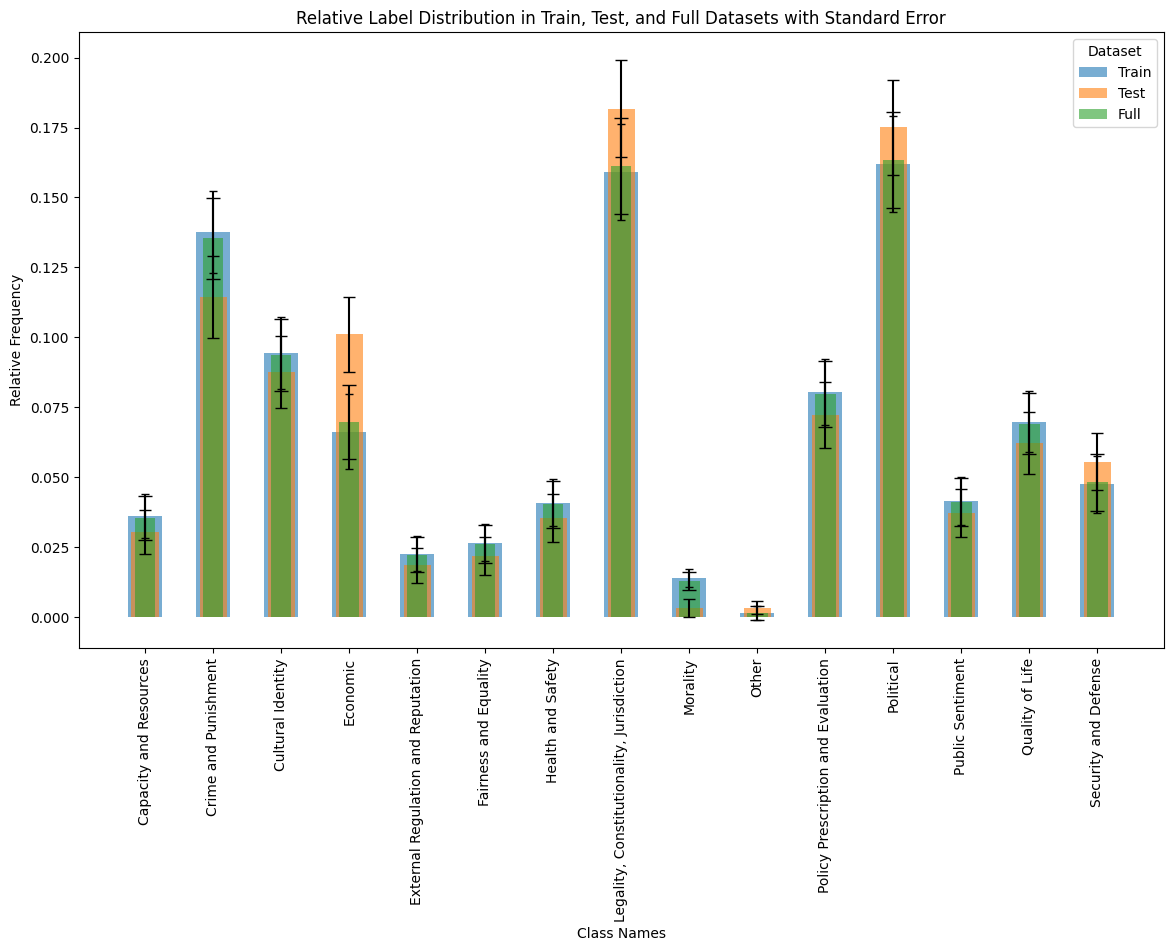

                                              Train      Test      Full  \
label_name                                                                
Capacity and Resources                     0.035969  0.030303  0.035401   
Crime and Punishment                       0.137692  0.114478  0.135367   
Cultural Identity                          0.094417  0.087542  0.093729   
Economic                                   0.066317  0.101010  0.069791   
External Regulation and Reputation         0.022668  0.018519  0.022252   
Fairness and Equality                      0.026602  0.021886  0.026129   
Health and Safety                          0.040839  0.035354  0.040290   
Legality, Constitutionality, Jurisdiction  0.159048  0.181818  0.161328   
Morality                                   0.013863  0.003367  0.012812   
Other                                      0.001311  0.003367  0.001517   
Policy Prescription and Evaluation         0.080555  0.072391  0.079737   
Political                

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
# Function to get label distribution
def get_label_distribution(df, class_names):
    # Extract labels using argmax
    df['label'] = df['encoded_values'].apply(lambda x: np.argmax(x))
    # Map labels to class names
    df['label_name'] = df['label'].apply(lambda x: class_names[x])
    # Get distribution
    distribution = df['label_name'].value_counts().sort_index()
    return distribution

# Get distributions for train, test, and full datasets
train_distribution = get_label_distribution(train_df, class_column_names)
test_distribution = get_label_distribution(test_df, class_column_names)

# Concatenate train and test datasets for full dataset
full_df = pd.concat([train_df, test_df])
full_distribution = get_label_distribution(full_df, class_column_names)

# Calculate relative frequencies
train_relative = train_distribution / train_distribution.sum()
test_relative = test_distribution / test_distribution.sum()
full_relative = full_distribution / full_distribution.sum()

# Combine into a single DataFrame
relative_df = pd.DataFrame({
    'Train': train_relative,
    'Test': test_relative,
    'Full': full_relative
}).fillna(0)

# Calculate standard error
se_df = np.sqrt(
    train_relative * (1 - train_relative) / len(train_df) + 
    test_relative * (1 - test_relative) / len(test_df) +
    full_relative * (1 - full_relative) / len(full_df)
)

# Plot the relative distribution with error bars
plt.figure(figsize=(14, 8))
plt.bar(relative_df.index, relative_df['Train'], alpha=0.6, label='Train', yerr=se_df, capsize=3, width=0.5)
plt.bar(relative_df.index, relative_df['Test'], alpha=0.6, label='Test', yerr=se_df, capsize=4, width=0.4)
plt.bar(relative_df.index, relative_df['Full'], alpha=0.6, label='Full', yerr=se_df, capsize=5, width=0.3)
plt.title('Relative Label Distribution in Train, Test, and Full Datasets with Standard Error')
plt.xlabel('Class Names')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=90)
plt.legend(title='Dataset')
plt.show()

# Display the relative distribution and standard error table
relative_df['SE'] = se_df
print(relative_df)